# Parcial 1 de Machine Learning

##  Análisis Exploratorio de Datos 


 (I) Considere la serie de tiempo asociada con las acciones de Bitcoin (ver Bitcoin data importe direc
tamente con el link y pd.read_csv). Realice un Análisis Exploratorio de Datos (EDA) considerando
 cada una de las metodología abordadas durante el curso. Es crucial que en todos los ejercicios
 de la presente evaluación, cada figura descriptiva, tabla o resumen de resultados, cuente con su
 respectiva interpretación

 * Utilice el conjunto de datos asociados con el precio de Bitcoin, ver (Bitcoin data). Considere
 para las predicciones con modelos de series de tiempo, la columna Price.

 * Identifique si existen datos faltantes y realice su imputación usando alguna de las técnicas
 básicas estudiadas durante el curso.

 ### Carga y procesamiento de datos

 Inicialmente, cargamos nuestra base de datos correspondiente a la información histórica del Bitcoin, reemplazamos las comas en las columnas de precios y corrigimos los sufijos de volumen ('K', 'M', 'B'). Luego procedemos a interpolar linealmente los valores faltantes y a relizar la imputación. 

In [9]:
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import statsmodels.api as sm #Import statsmodels here
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose #Corrected import

import warnings

warnings.filterwarnings("ignore")

# 1. Data Loading and Preprocessing:
data = pd.read_csv('c:/Users/Johal/Documents/Uninorte/SeriesdeTiempo/MachineLearning/Bitcoin Historical Data.csv', parse_dates=['Date'])

# Data Cleaning: Remove commas, handle 'K', 'M', and 'B' suffixes in 'Vol.' column, and convert to numeric.

for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].astype(str).str.replace(',', '', regex=False).astype(float)

# Handle 'K', 'M', and 'B' suffixes in 'Vol.' column
data['Vol.'] = (
    data['Vol.']
    .astype(str)
    .str.replace('[KMB]', '', regex=True)
    .astype(float)
    .replace(0, np.nan)
)
data['Vol.'] = data['Vol.'].mask(data['Vol.'].astype(str).str.contains('K'), data['Vol.'] * 1000)
data['Vol.'] = data['Vol.'].mask(data['Vol.'].astype(str).str.contains('M'), data['Vol.'] * 1000000)
data['Vol.'] = data['Vol.'].mask(data['Vol.'].astype(str).str.contains('B'), data['Vol.'] * 1000000000)


#Check for missing values BEFORE imputation
missing_before = data.isnull().sum()
print("\nMissing values BEFORE imputation:\n", missing_before)


# Handle missing values after cleaning (linear interpolation)
data.interpolate(method='linear', inplace=True, limit_direction='both')

#Check for missing values AFTER imputation
missing_after = data.isnull().sum()
print("\nMissing values AFTER imputation:\n", missing_after)



Missing values BEFORE imputation:
 Date        0
Price       0
Open        0
High        0
Low         0
Vol.        6
Change %    0
dtype: int64

Missing values AFTER imputation:
 Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


Se elige la interpolación lineal porque supone una relación lineal entre puntos de datos consecutivos. Esta es una suposición razonable para una serie temporal como los precios de Bitcoin, especialmente cuando los valores faltantes están dispersos y no agrupados en rangos de tiempo específicos.  La interpolación lineal es un método simple pero eficaz para completar los datos faltantes. Es posible que no sean necesarios métodos más complejos dada la volatilidad inherente y las fluctuaciones a corto plazo en los precios de Bitcoin.

* Realice un grafico de velas utilizando la librería Plotly para la serie de tiempo (columna Price).
 Realice también un histograma con Plotly para representar el volumen tradeado diariamente
 (Volume)

 ### Gráfico de velas para la serie de tiempo Precio e Histrograma para la serie de tiempo Volumen

In [10]:
# 2. Price Plot (Candlestick Chart):
fig = go.Figure(data=[go.Candlestick(x=data['Date'], open=data['Open'], high=data['High'],
                                     low=data['Low'], close=data['Price'])])
fig.update_layout(title='Bitcoin Price Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()

# 3. Volume Histogram:
fig = go.Figure(data=[go.Histogram(x=data['Vol.'])])
fig.update_layout(title='Distribution of Daily Bitcoin Trading Volume', xaxis_title='Volume', yaxis_title='Frequency')

fig.show()

Del **gráfico de velas** para el precio podemos observar que la tendencia general es fuertemente ascendente, especialmente notable entre 2010 y 2024 aproximadamente. Igualmente, se evidencia una volatilidad considerable, ya que hay períodos de fuertes aumentos de precios (mercados alcistas) y fuertes caídas (mercados bajistas). El tamaño de las velas representa visualmente las fluctuaciones de precios dentro de cada período de tiempo, lo que muestra que las oscilaciones de precios pueden ser bastante sustanciales.

También visualizamos varios picos de precios significativos a lo largo del gráfico. Después de cada aumento sustancial, hay un período de corrección o consolidación en el que el precio retrocede antes de continuar su movimiento ascendente, lo cual es típico del comportamiento volátil de los precios de los activos. Es notable un aumento en el precio de Bitcoin hacia el final del período (2023-2024). 

Por otro lado, **el histograma** muestra una distribución fuertemente sesgada a la derecha. Esto significa que hay muchos días con un volumen de operaciones relativamente bajo y algunos días con un volumen de operaciones excepcionalmente alto.  La cola se extiende hacia la derecha, lo que indica algunos valores atípicos o días con una actividad comercial significativamente mayor.

El pico del histograma se encuentra en el extremo inferior del rango de volumen, lo que significa que el volumen de operaciones diario observado con más frecuencia es relativamente bajo. Mientras que la cola larga hacia la derecha sugiere que los eventos extremos (días con un alto volumen de operaciones) ocurren con menos frecuencia pero aún contribuyen sustancialmente al volumen general.


* Realice graficos de subseries considerando agrupación por semana, mes y año. Utilice graficos
 de series de tiempo y boxplots para analizar estas subseries.

 ### Gráficos de subseries

In [11]:
# 4. Subseries Plots (Weekly, Monthly, Yearly):
for freq in ['W', 'M', 'Y']:
    subseries = data.resample(freq, on='Date')['Price'].mean()
    fig = go.Figure(data=[go.Scatter(x=subseries.index, y=subseries)])
    fig.update_layout(title=f'{freq}-ly Average Bitcoin Price', xaxis_title='Date', yaxis_title='Price')
    fig.show()

# Nuevo: Diagrama de cajas
data['Period'] = data['Date'].dt.to_period('M').astype(str)  # Convierte a string
box_plot_fig = px.box(data, x='Period', y='Price', title='Box Plot of Bitcoin Prices by Period')
box_plot_fig.show()

De los gráficos anteriores podemos concluir lo siguiente:

1. Precio promedio semanal de Bitcoin: El gráfico muestra una alta volatilidad con múltiples picos, especialmente notables a partir de 2017, lo que indica fluctuaciones significativas en períodos cortos.

2. Precio promedio mensual de Bitcoin: La tendencia es similar al gráfico semanal pero más suave, lo que ilustra una tendencia ascendente general más clara con picos importantes a finales de 2017, principios de 2021 y otro aumento hacia 2024.

3. Precio promedio anual de Bitcoin: Este gráfico indica una tendencia ascendente más consistente a lo largo de los años, con aumentos marcados, particularmente a partir de 2020.

En general, todos los gráficos muestran el crecimiento general de los precios de Bitcoin, con picos notables que reflejan períodos de mayor actividad y adopción del mercado.

* Estudie estacionariedad de la serie de tiempo usando la ACF estudiada durante el curso, así como también los respectivos test estadísticos tales como Ljung-Box y Dickey Fuller. Aplique además las transformaciones necesarias para convertir la serie de tiempo en estacionaria.

### Estacionariedad

Stationarity Tests (ADF and KPSS):

Testing for stationarity in Price:
ADF Statistic: -2.685798
p-value: 0.076528
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
KPSS Statistic: 7.495400
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


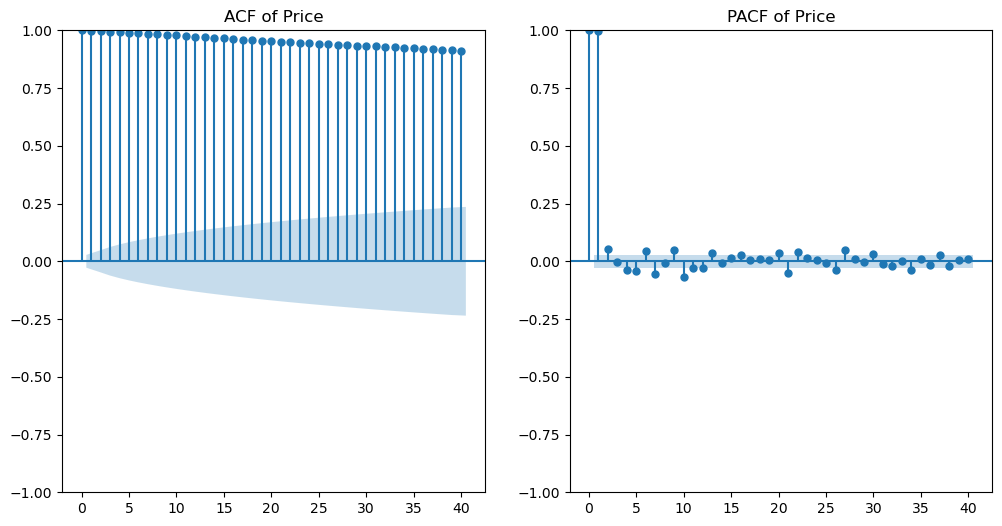


After Differencing:
ADF Statistic: -10.472194
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
KPSS Statistic: 0.266851
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


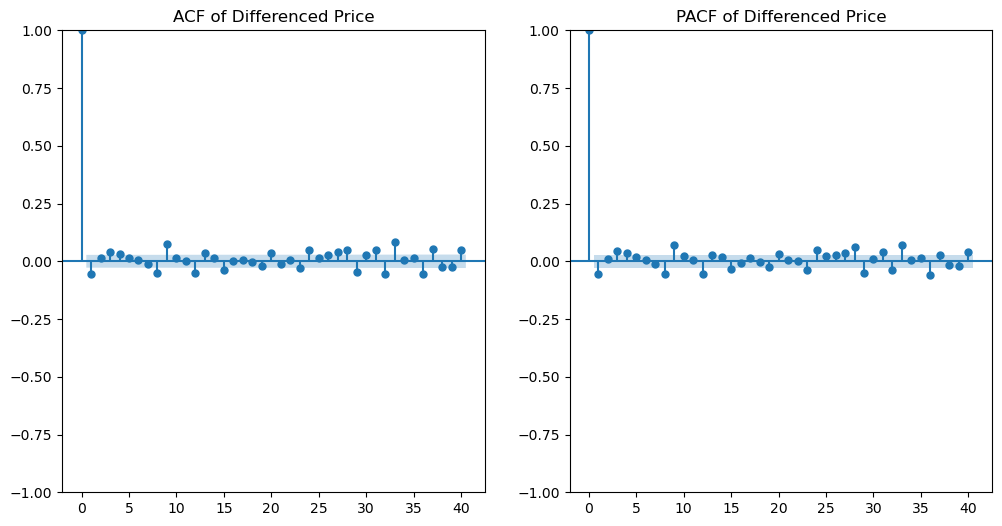


Ljung-Box Test Result:
     lb_stat     lb_pvalue
10  72.61667  1.381782e-11

Dickey-Fuller Test on Original Data:
ADF Statistic: -2.685798
p-value: 0.076528

Dickey-Fuller Test on Differenced Data:
ADF Statistic: -10.472194
p-value: 0.000000


In [12]:
# 5. Stationarity Tests (ADF and KPSS) and ACF/PACF Plots:
print("Stationarity Tests (ADF and KPSS):")
for col in ['Price']:  # Test for the original and transformed data if needed. Add more columns as needed
    print(f"\nTesting for stationarity in {col}:")
    result = adfuller(data[col])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    kpss_result = kpss(data[col])
    print('KPSS Statistic: %f' % kpss_result[0])
    print('p-value: %f' % kpss_result[1])
    print('Critical Values:')
    for key, value in kpss_result[3].items():
        print('\t%s: %.3f' % (key, value))

    # ACF and PACF plots for original data
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plot_acf(data['Price'], lags=40, ax=plt.gca())
    plt.title('ACF of Price')
    
    plt.subplot(1, 2, 2)
    plot_pacf(data['Price'], lags=40, ax=plt.gca())
    plt.title('PACF of Price')
    
    plt.show()

    # Transformation for Stationarity: Differencing
    data['Price_diff'] = data['Price'].diff().dropna()

    # Re-run the stationarity tests on the differenced data
    result_diff = adfuller(data['Price_diff'].dropna())
    print('\nAfter Differencing:')
    print('ADF Statistic: %f' % result_diff[0])
    print('p-value: %f' % result_diff[1])
    print('Critical Values:')
    for key, value in result_diff[4].items():
        print('\t%s: %.3f' % (key, value))

    kpss_result_diff = kpss(data['Price_diff'].dropna())
    print('KPSS Statistic: %f' % kpss_result_diff[0])
    print('p-value: %f' % kpss_result_diff[1])
    print('Critical Values:')
    for key, value in kpss_result_diff[3].items():
        print('\t%s: %.3f' % (key, value))

    # ACF and PACF plots for differenced data
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plot_acf(data['Price_diff'].dropna(), lags=40, ax=plt.gca())
    plt.title('ACF of Differenced Price')
    
    plt.subplot(1, 2, 2)
    plot_pacf(data['Price_diff'].dropna(), lags=40, ax=plt.gca())
    plt.title('PACF of Differenced Price')
    
    plt.show()

    # Ljung-Box Test on Differenced Data
    ljung_box_result = acorr_ljungbox(data['Price_diff'].dropna(), lags=[10], return_df=True)
    print("\nLjung-Box Test Result:")
    print(ljung_box_result)

    # Perform Dickey-Fuller test on the original data
    dickey_fuller_result = adfuller(data['Price'].dropna())
    print("\nDickey-Fuller Test on Original Data:")
    print('ADF Statistic: %f' % dickey_fuller_result[0])
    print('p-value: %f' % dickey_fuller_result[1])

    # Perform Dickey-Fuller test on differenced data
    dickey_fuller_diff_result = adfuller(data['Price_diff'].dropna())
    print("\nDickey-Fuller Test on Differenced Data:")
    print('ADF Statistic: %f' % dickey_fuller_diff_result[0])
    print('p-value: %f' % dickey_fuller_diff_result[1])

De lo anterior, podemos concluir que:

1. **Antes de la diferenciación:** La serie de precios de Bitcoin es no estacionaria, según ambos tests.
2. **Después de la diferenciación:** La serie se vuelve estacionaria, como lo indican los resultados del test ADF y el test KPSS.

*Después de la diferenciación*, el valor ADF (-10.472194) es mucho menor que el umbral crítico (1% = -3.432), lo que permite rechazar la hipótesis nula de no estacionariedad. Adicionalmente, El p-value (0.000000) está claramente por debajo de 0.05, confirmando que la serie de tiempo es estacionaria después de aplicar la diferenciación.
*Después de la diferenciación*, el valor KPSS (0.266851) es menor que el umbral crítico del 10% (0.347), lo que no permite rechazar la hipótesis nula de estacionariedad. Adicionalmnete, el p-value (0.100000) es mayor que 0.05, corroborando que la serie puede considerarse estacionaria después de la diferenciación.

Esto sugiere que la diferenciación es un enfoque efectivo para estabilizar la serie de tiempo de precios de Bitcoin, lo cual es crucial para la modelización utilizando métodos como ARIMA.

Adicionalmente, **El test de Ljung-Box** evalúa la hipótesis nula de que no hay autocorrelación en los residuos de la serie temporal hasta el rezago especificado (en este caso, 10 rezagos). Dado que el p-valor es significativamente menor que 0.05, rechazamos la hipótesis nula. *Esto indica que hay autocorrelación presente en los residuos. En otras palabras, los residuos son no independientes y sugieren que el modelo actual no está capturando completamente la estructura de la serie temporal.*

Finalmente,  por medio del **test Dickey-Fuller en los datos originales** (Siendo el ADF Statistic de -2.685798 y el p-valor de 0.076528) podemos concluir que no se puede rechazar la hipótesis nula de no estacionariedad en la serie original. Adicionalmente, como el p-valor es mayor que 0.05, esto sugiere que la serie original de precios de Bitcoin tiene una tendencia no estacionaria. 
Mientras que por medio del **test Dickey-Fuller en los datos diferenciados** (Siendo el ADF Statistic de -10.472194 y el p-valor de 0.000000) podemos concluir que sí se puede rechazar la hipótesis nula de no estacionariedad en los datos diferenciados.
Esto significa que, tras aplicar la diferenciación a la serie de tiempo, la serie resultante es estacionaria, lo que es un resultado esperado al aplicar el procedimiento de diferenciación.

*  Mediante agregación por grupos analice el comportamiento de la media y desviación estándar,
 agrupando por semanas, días, meses. Además, para estas agrupaciones, calcule estadísticos
 móviles.  Dibuje la distribución de frecuencias para diferentes lags como se realizó en las notas de curso.

 ### Estadísticos móviles

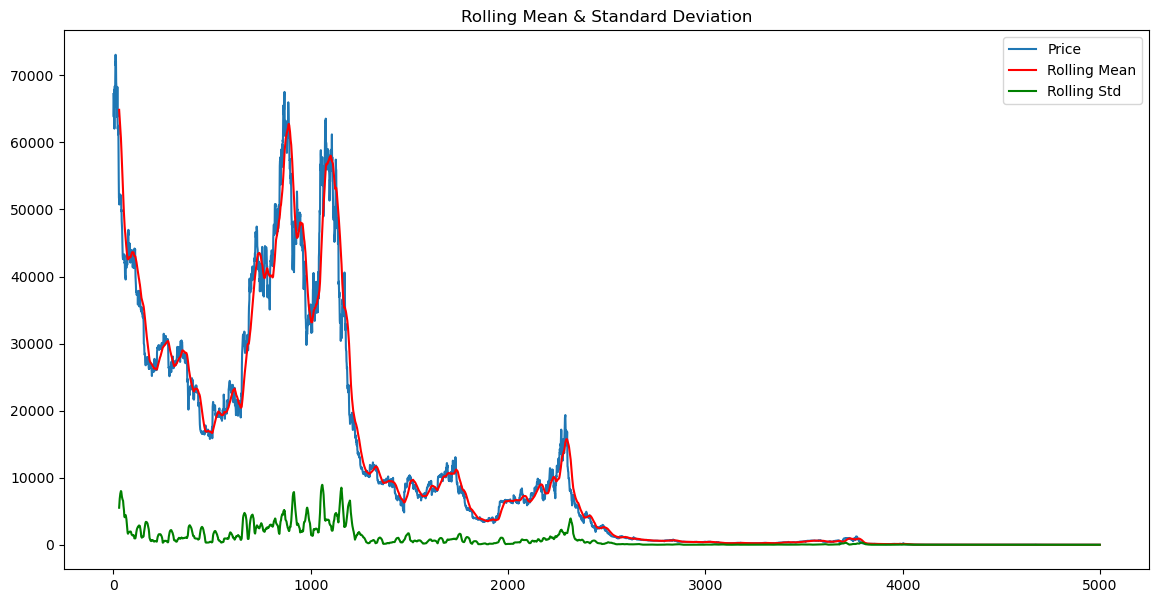

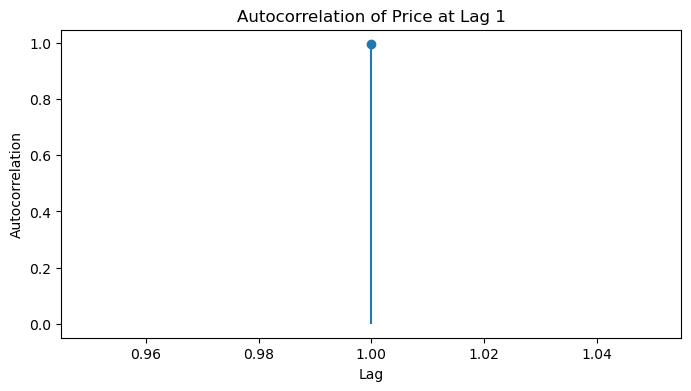

Ljung-Box test for lag 1: statistic=14.84, p-value=0.000


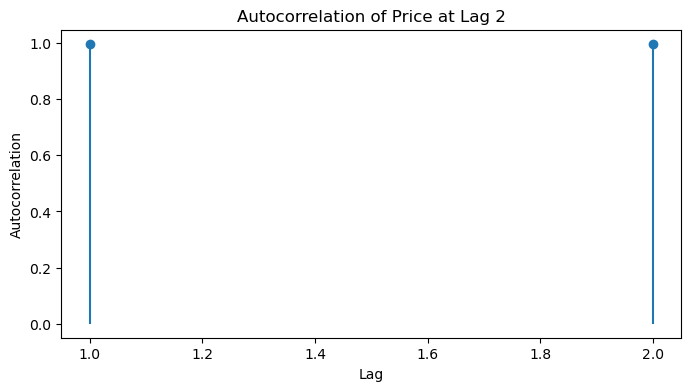

Ljung-Box test for lag 2: statistic=15.67, p-value=0.000


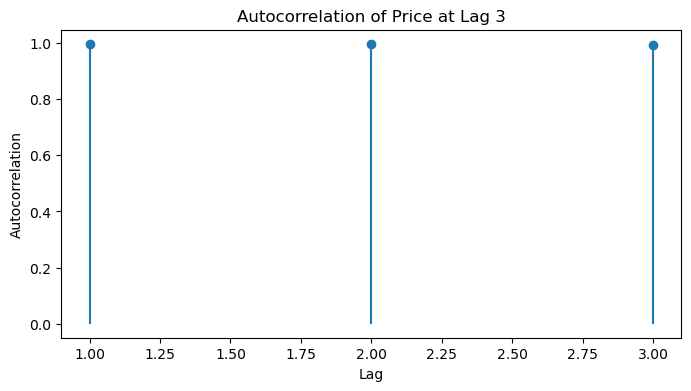

Ljung-Box test for lag 3: statistic=24.22, p-value=0.000


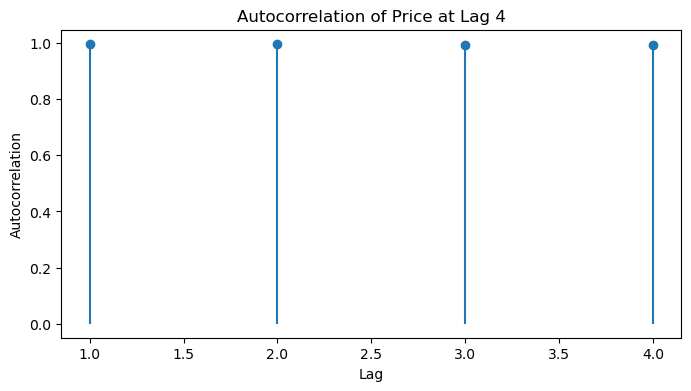

Ljung-Box test for lag 4: statistic=28.94, p-value=0.000


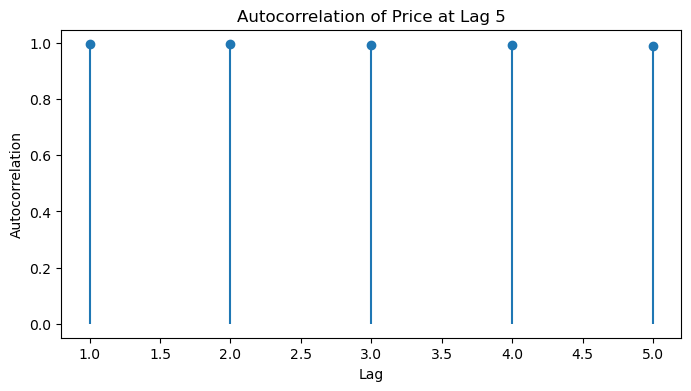

Ljung-Box test for lag 5: statistic=30.08, p-value=0.000


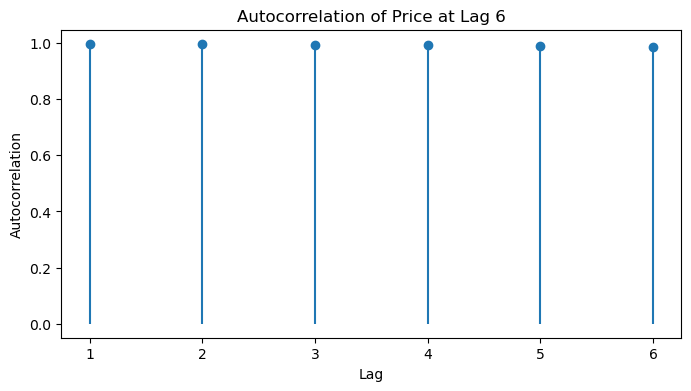

Ljung-Box test for lag 6: statistic=30.36, p-value=0.000


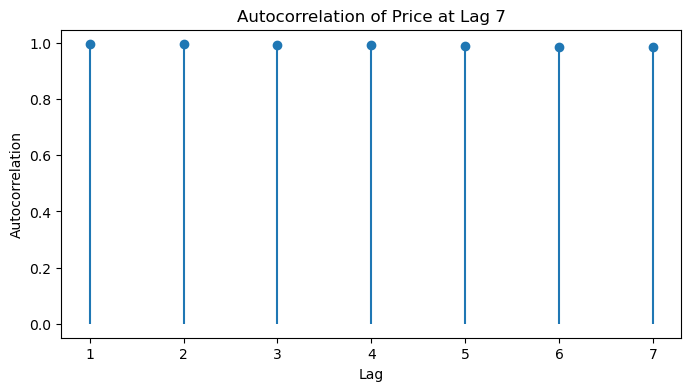

Ljung-Box test for lag 7: statistic=30.87, p-value=0.000


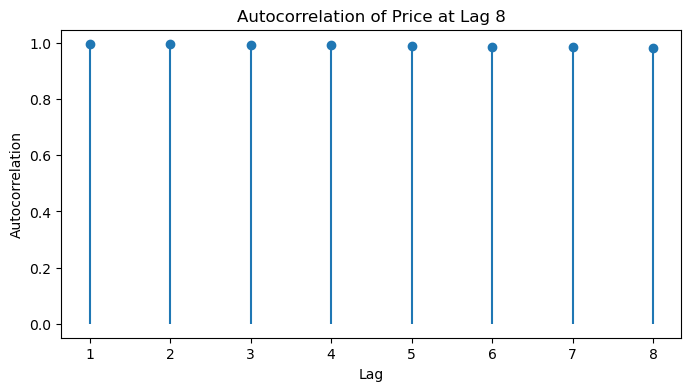

Ljung-Box test for lag 8: statistic=42.89, p-value=0.000


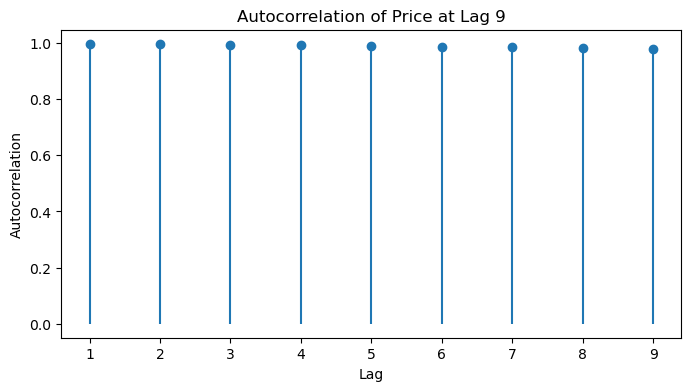

Ljung-Box test for lag 9: statistic=71.78, p-value=0.000


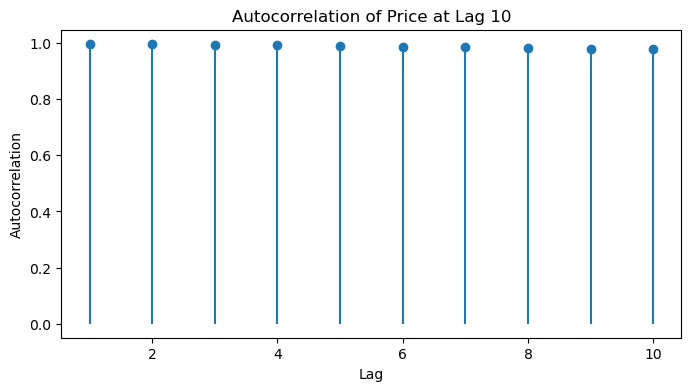

Ljung-Box test for lag 10: statistic=72.62, p-value=0.000


In [13]:

from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# 6. Rolling Statistics (Mean and Standard Deviation):
window = 30  # Example window size
data['RollingMean'] = data['Price'].rolling(window).mean()
data['RollingStd'] = data['Price'].rolling(window).std()

# Plot Rolling Statistics (Optional): - Add plots as needed
plt.figure(figsize=(14, 7))
plt.plot(data['Price'], label='Price')
plt.plot(data['RollingMean'], label='Rolling Mean', color='red')
plt.plot(data['RollingStd'], label='Rolling Std', color='green')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()

# 7. Distribution of Frequencies for Different Lags (Autocorrelation):
lags = range(1, 11)  # Example lags. Adjust as needed
for lag in lags:
    autocorr = acf(data['Price'], nlags=lag)[1:]  # Compute autocorrelation
    plt.figure(figsize=(8, 4))
    plt.stem(range(1, lag + 1), autocorr, basefmt=" ")
    plt.title(f'Autocorrelation of Price at Lag {lag}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

    # Perform Ljung-Box test for the given lag
    ljung_box_result = acorr_ljungbox(data['Price_diff'].dropna(), lags=[lag], return_df=True)
    lb_statistic = ljung_box_result['lb_stat'].values[0]
    p_value = ljung_box_result['lb_pvalue'].values[0]

    print(f"Ljung-Box test for lag {lag}: statistic={lb_statistic:.2f}, p-value={p_value:.3f}")


De los **estadísticos móviles**, podemos notoriamente observar la volatilidad de los precios de Bitcoin que queda ilustrada por los altos picos en la línea verde *(desviación estándar móvil)*, especialmente durante períodos de rápidos cambios de precios.
La línea roja *(media móvil)* ayuda a visualizar tendencias generales, incluso si se suaviza el momento exacto. El gráfico muestra claramente períodos de importantes caídas de precios.
Adicionalmente,el gráfico sugiere que los datos del precio de Bitcoin no son estacionarios *(no tienen una media ni una varianza constantes a lo largo del tiempo)*. Esto es típico de los datos de series temporales financieras. El uso de estadísticas móviles suele ser un primer paso antes de aplicar modelos de series temporales que requieren estacionariedad (como ARIMA).

La hipótesis nula del test de Ljung-Box es que no hay autocorrelación en los residuos hasta el rezago especificado. Esto significa que los residuos son independientes y que el modelo es adecuado.

Para todos los rezagos evaluados (1 a 10), el estadístico de Ljung-Box es significativamente alto, y el p-valor asociado es 0.000 en todos los casos. Esto indica que, en todos los lag, se rechaza la hipótesis nula de no autocorrelación.

1. Presencia de Autocorrelación: Los resultados muestran que hay una fuerte evidencia de autocorrelación en los residuos de tu modelo, lo que sugiere que el modelo actual no está capturando completamente la estructura de la serie temporal.
2. Necesidad de Ajustes: Dado que los residuos muestran autocorrelación, es posible que necesites ajustar tu modelo. Esto puede incluir el uso de términos adicionales en el modelo (por ejemplo, un modelo ARIMA con órdenes (p, d, q) que reflejen la estructura de autocorrelación del conjunto de datos).

### Aplicación de medias móviles y verificación de estacionariedad

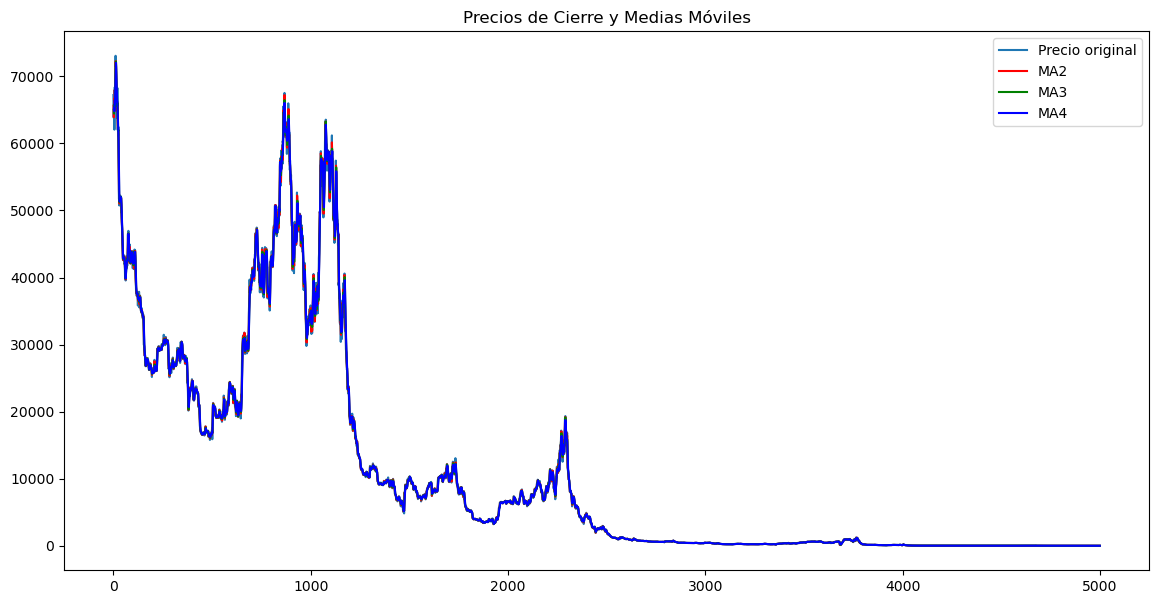


ADF Test for MA2:
ADF Statistic: -2.693873
p-value: 0.075105

KPSS Test for MA2:
KPSS Statistic: 7.494636
p-value: 0.010000

ADF Test for MA3:
ADF Statistic: -2.621698
p-value: 0.088595

KPSS Test for MA3:
KPSS Statistic: 7.493961
p-value: 0.010000

ADF Test for MA4:
ADF Statistic: -2.709959
p-value: 0.072331

KPSS Test for MA4:
KPSS Statistic: 7.493350
p-value: 0.010000

Ljung-Box Test Result for MA2:
         lb_stat  lb_pvalue
10  48907.369783        0.0

Ljung-Box Test Result for MA3:
         lb_stat  lb_pvalue
10  48922.677176        0.0

Ljung-Box Test Result for MA4:
         lb_stat  lb_pvalue
10  48930.891205        0.0


In [14]:
# 8. Applying Moving Averages and Stationarity Checks:

#Calculate moving averages
data['MA2'] = data['Price'].rolling(window=2).mean()
data['MA3'] = data['Price'].rolling(window=3).mean()
data['MA4'] = data['Price'].rolling(window=4).mean()

#Plot moving averages along with original prices
plt.figure(figsize=(14,7))
plt.plot(data['Price'], label='Precio original')
plt.plot(data['MA2'], label='MA2', color='red')
plt.plot(data['MA3'], label='MA3', color='green')
plt.plot(data['MA4'], label='MA4', color='blue')
plt.legend()
plt.title('Precios de Cierre y Medias Móviles')
plt.show()

#Stationarity tests for moving averages
for col in ['MA2','MA3','MA4']: #test for each MA
    result = adfuller(data[col].dropna())
    print(f"\nADF Test for {col}:")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

    kpss_result = kpss(data[col].dropna())
    print(f"\nKPSS Test for {col}:")
    print('KPSS Statistic: %f' % kpss_result[0])
    print('p-value: %f' % kpss_result[1])

#Ljung-Box test for moving averages
for col in ['MA2', 'MA3', 'MA4']:
    ljung_box_result = acorr_ljungbox(data[col].dropna(), lags=[10], return_df=True)
    print(f"\nLjung-Box Test Result for {col}:")
    print(ljung_box_result)

La estadística ADF mide qué tan lejos de cero están los datos; cuanto más negativo, mejor. El valor p es lo crítico para rechazar la hipótesis nula de no estacionariedad.

Los tres valores p de MA (0,075105, 0,088595 y 0,072331) están por encima del nivel de significancia común de 0,05. Por lo tanto, no podemos rechazar la hipótesis nula de no estacionariedad para cada media móvil. Esto sugiere que las medias móviles en sí mismas no son estacionarias.

La prueba KPSS tiene una hipótesis nula de estacionariedad. Por tanto, buscamos un valor p alto. Las tres pruebas KPSS muestran valores de p de 0,01. Esto está por debajo de 0,05, lo que nos lleva a rechazar la hipótesis nula de estacionariedad. Esto refuerza los resultados de la prueba ADF: las medias móviles no son estacionarias.

En los resultados aparece una advertencia de interpolación, que surge porque la estadística de prueba KPSS es muy grande. La tabla de búsqueda de la prueba KPSS tiene un rango limitado de valores, por lo que no puede calcular con precisión el valor p para estadísticas de prueba extremadamente altas. La advertencia simplemente significa que el valor p real es incluso menor que 0,01, lo que hace que el rechazo de la estacionariedad sea aún más fuerte.

La prueba de Ljung-Box rectifica la autocorrelación en los residuos (en este caso es después de diferenciar y después de aplicar la media móvil). Los tres valores p de Ljung-Box son 0,0. Esto sugiere fuertemente que queda una autocorrelación significativa en los datos incluso después de diferenciar y calcular el promedio móvil.

### Descomposición de la serie temporal

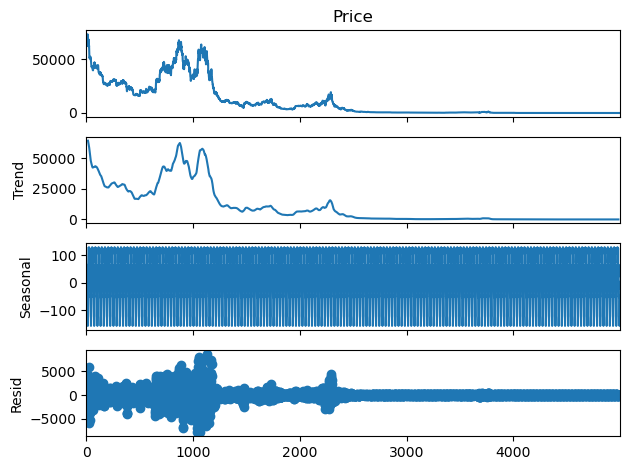


Ljung-Box Test on Residuals from Decomposition:
        lb_stat  lb_pvalue
10  7996.293351        0.0


In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose #Corrected import
decomposition = seasonal_decompose(data['Price'], model='additive', period=30)
decomposition.plot()
plt.show()

# Access the residual component correctly
residuals = decomposition.resid

# Handle potential NaN values in residuals (important step)
residuals = residuals.dropna()

# Ljung-Box test on residuals from decomposition
ljung_box_result_decomp = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung-Box Test on Residuals from Decomposition:")
print(ljung_box_result_decomp)

El valor p muy bajo y el lb_stat grande sugieren fuertemente que los residuos de su descomposición estacional no son independientes y queda una autocorrelación significativa en los residuos. 

El gráfico de descomposición de la serie temporal sugiere que el precio de Bitcoin está impulsado en gran medida por una tendencia a largo plazo, con un período de 30 que no captura ninguna estacionalidad obvia.   Los patrones sustanciales evidentes en los residuos y los resultados anteriores de la prueba Ljung-Box indican claramente que este modelo de descomposición aditiva con un período de 30 no es apropiado para modelar los datos del precio de Bitcoin.

###  Retorno acumulado diario y volatilidad para diferentes ventanas


Analysis for Volatility_7:
ADF Statistic: -7.467584
p-value: 0.000000
KPSS Statistic: 1.753535
p-value: 0.010000


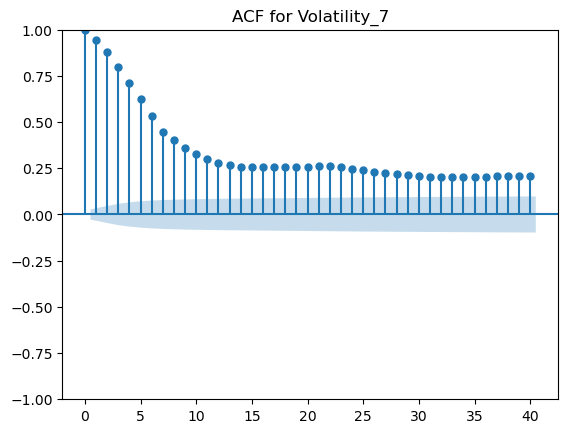

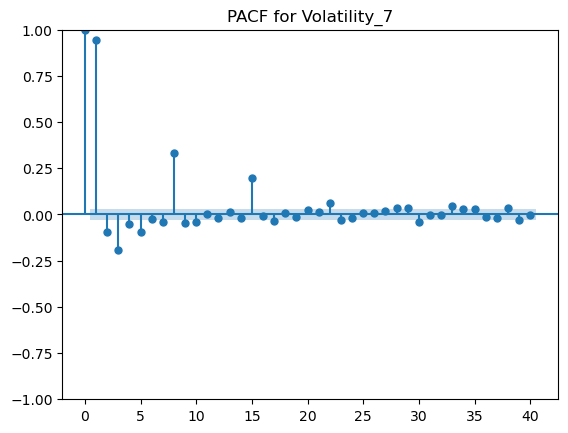


Analysis for CumulativeReturn_7:
ADF Statistic: -12.009577
p-value: 0.000000
KPSS Statistic: 0.095078
p-value: 0.100000


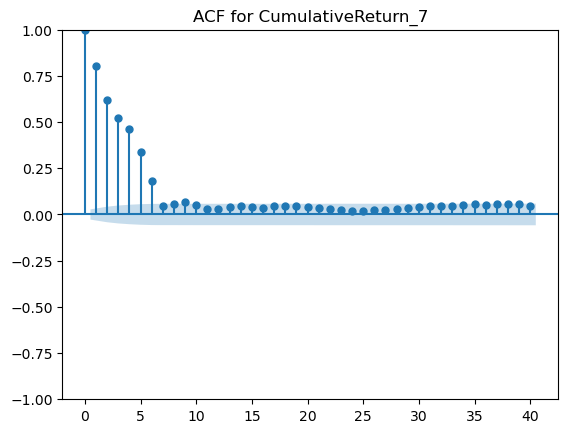

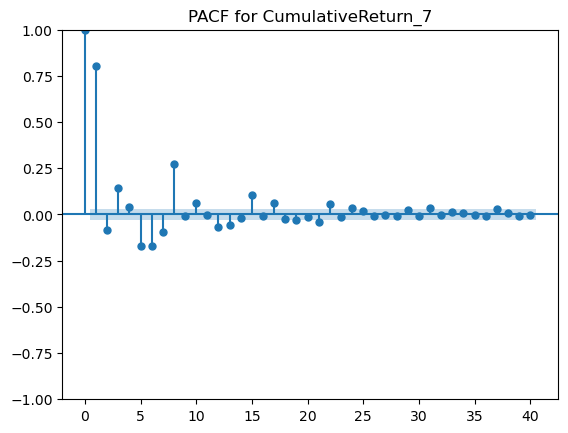


Analysis for Volatility_14:
ADF Statistic: -6.800437
p-value: 0.000000
KPSS Statistic: 1.826942
p-value: 0.010000


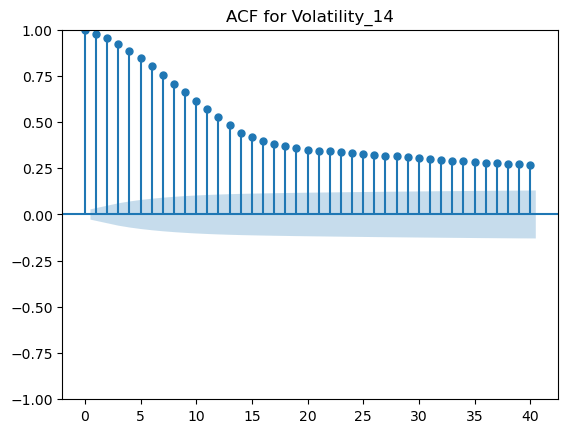

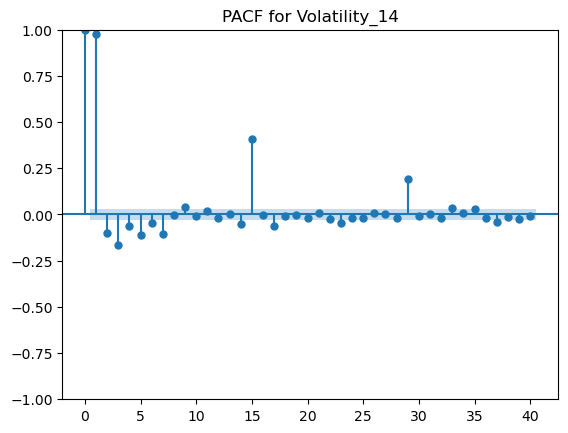


Analysis for CumulativeReturn_14:
ADF Statistic: -9.393575
p-value: 0.000000
KPSS Statistic: 0.085825
p-value: 0.100000


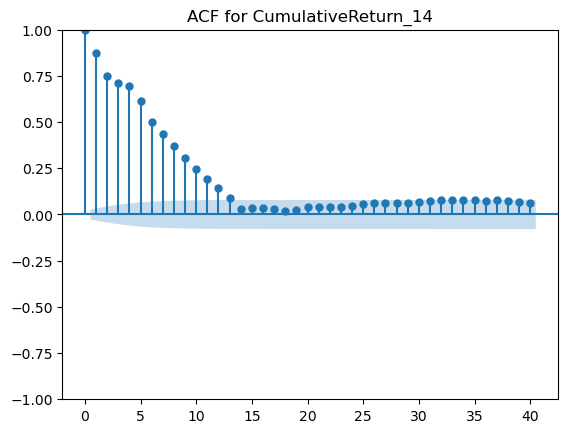

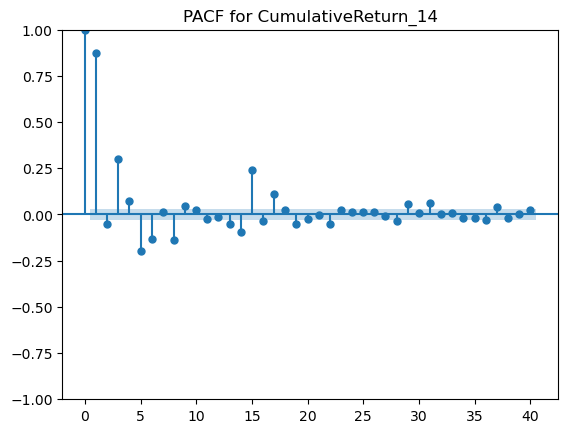


Analysis for Volatility_21:
ADF Statistic: -6.746098
p-value: 0.000000
KPSS Statistic: 1.880053
p-value: 0.010000


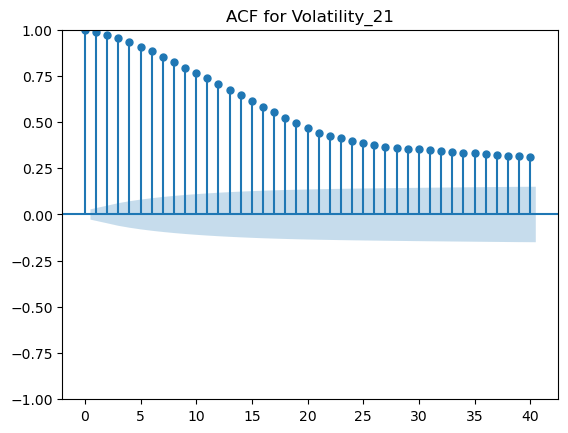

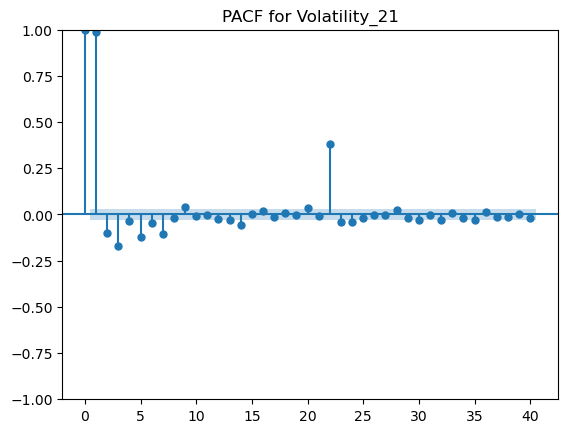


Analysis for CumulativeReturn_21:
ADF Statistic: -8.569582
p-value: 0.000000
KPSS Statistic: 0.084423
p-value: 0.100000


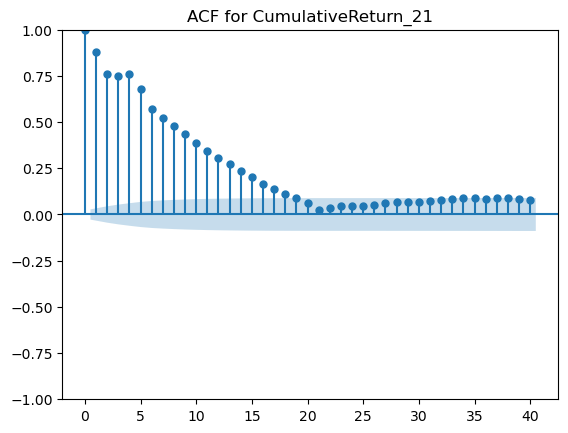

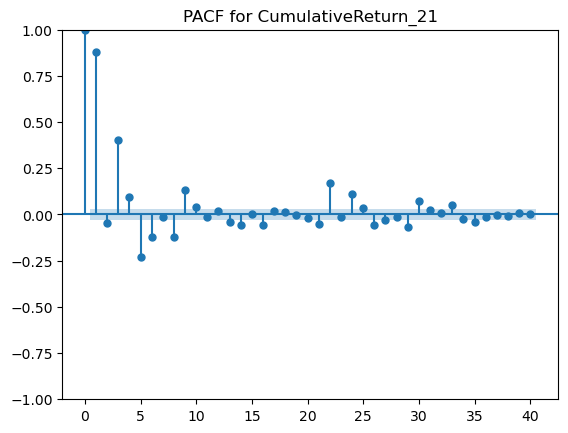


Analysis for Volatility_28:
ADF Statistic: -5.342915
p-value: 0.000004
KPSS Statistic: 1.945431
p-value: 0.010000


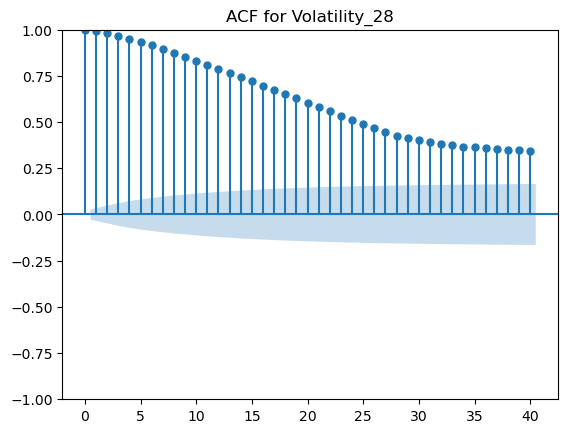

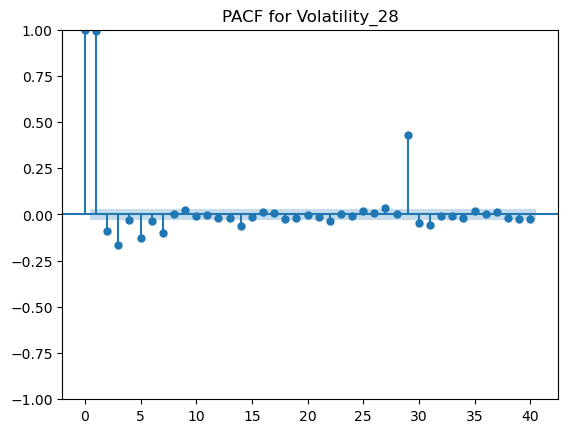


Analysis for CumulativeReturn_28:
ADF Statistic: -8.165056
p-value: 0.000000
KPSS Statistic: 0.089400
p-value: 0.100000


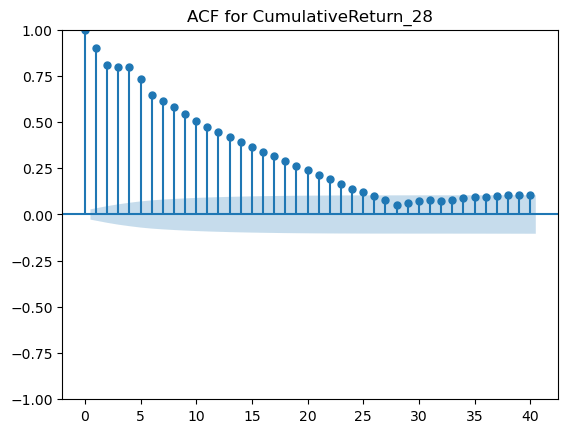

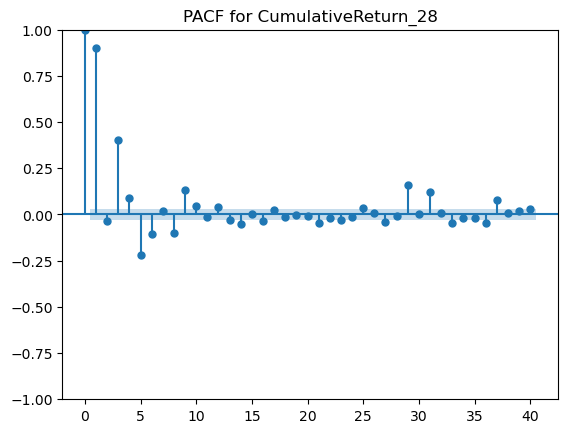

In [16]:
# Calculate daily returns
data['Return'] = data['Price'].pct_change()  # Percentage change
data['Return'].dropna(inplace=True) #remove first NaN


#Function to calculate volatility
def calculate_volatility(series, window):
    returns = series.pct_change()
    returns = returns.dropna()
    rolling_std = returns.rolling(window=window).std()
    return rolling_std


# Window sizes for volatility calculation
windows = [7, 14, 21, 28]

#Function to calculate cumulative return
def calculate_cumulative_return(series, window):
    returns = series.pct_change()
    returns = returns.dropna()
    cum_returns = (1 + returns).rolling(window=window).apply(lambda x: np.prod(x) - 1)
    return cum_returns

for window in windows:
    data[f'Volatility_{window}'] = calculate_volatility(data['Price'], window)
    data[f'CumulativeReturn_{window}'] = calculate_cumulative_return(data['Price'],window)


# --- Repeating analysis for different window sizes of Volatility and Cumulative Return ---
for window in windows:
    print(f"\nAnalysis for Volatility_{window}:")
    result = adfuller(data[f'Volatility_{window}'].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

    kpss_result = kpss(data[f'Volatility_{window}'].dropna())
    print('KPSS Statistic: %f' % kpss_result[0])
    print('p-value: %f' % kpss_result[1])

    plot_acf(data[f'Volatility_{window}'].dropna(), lags=40)
    plt.title(f'ACF for Volatility_{window}')
    plt.show()
    plot_pacf(data[f'Volatility_{window}'].dropna(), lags=40)
    plt.title(f'PACF for Volatility_{window}')
    plt.show()

    print(f"\nAnalysis for CumulativeReturn_{window}:")
    result = adfuller(data[f'CumulativeReturn_{window}'].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

    kpss_result = kpss(data[f'CumulativeReturn_{window}'].dropna())
    print('KPSS Statistic: %f' % kpss_result[0])
    print('p-value: %f' % kpss_result[1])

    plot_acf(data[f'CumulativeReturn_{window}'].dropna(), lags=40)
    plt.title(f'ACF for CumulativeReturn_{window}')
    plt.show()
    plot_pacf(data[f'CumulativeReturn_{window}'].dropna(), lags=40)
    plt.title(f'PACF for CumulativeReturn_{window}')
    plt.show()

Todas las series de rentabilidades acumulativas muestran valores de p muy bajos en la prueba ADF (todas 0,000000), lo que sugiere fuertemente estacionariedad.  Las pruebas KPSS también muestran valores p altos (todos 0,100000), lo que respalda la conclusión de estacionariedad.  Esto indica que los rendimientos acumulados diarios probablemente sean estacionarios en todos los tamaños de ventana considerados.

Adicionalmente, las series de volatilidad muestran valores p bajos en la prueba ADF (todos por debajo de 0,05), lo que sugiere estacionariedad. Sin embargo, las pruebas KPSS muestran valores de p bajos (todos 0,010000), lo que indica no estacionariedad.  Este conflicto sugiere que la serie de volatilidad podría no ser estacionaria o al menos estar cerca del límite entre un comportamiento estacionario y no estacionario.

El análisis sugiere que los rendimientos acumulados diarios de los precios de Bitcoin probablemente sean estacionarios independientemente del tamaño de la ventana utilizada en el cálculo.  La volatilidad, sin embargo, presenta un panorama más complejo y potencialmente muestra no estacionariedad.  Los resultados contradictorios de las pruebas de volatilidad de ADF y KPSS resaltan la importancia de considerar múltiples pruebas estadísticas e interpretar cuidadosamente sus resultados.  Puede ser necesario seguir investigando las características de las series temporales de volatilidad para llegar a una conclusión más definitiva.  Se podrían utilizar técnicas como el análisis de rupturas estructurales u otras pruebas de estacionariedad para analizar más a fondo las series temporales de volatilidad.